In [ ]:
mylogintoken = input('your login API token here: ')

your login API token here: d7c82d573d72a8eeda1f8279d9d20efd05c9336611ce71ddbc4891852349bcfa6584166be033bde5ddcbe575c3b913c276cfd2128e63fadd61fc56c052f387e0


In [ ]:
 %pip install qiskit ipywidgets
 %pip install qiskit-aer
 %pip install qiskit-ibm-provider
 %pip install pylatexenc
 %pip install qiskit-ibm-runtime

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import qiskit
from qiskit import *
import numpy as np
import pprint
import random
from qiskit.visualization import plot_histogram
from qiskit.visualization import array_to_latex
from qiskit.quantum_info.operators import Operator
from qiskit_aer import AerSimulator, StatevectorSimulator


%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session
service = QiskitRuntimeService(channel="ibm_quantum", token=mylogintoken)

In [ ]:
#
# Evaluate the state vector of the supplied circuit and return the associated ket
#
def sv(qc, shots=1):
    aersim = StatevectorSimulator()
    job = aersim.run(qc, shots=shots)
    ket = job.result().get_statevector()
    return ket

def em(qc, shots=1):
    simulator = AerSimulator()
    # Run and get counts
    result = simulator.run(qc, shots=shots).result()
    hist = result.get_counts()
    return hist

In [ ]:
#
# create a standard 1 bit circuit
#   with 1 quantum register
#   and  1 classical register with n bits
#

def genQC(n):
    qc = QuantumCircuit()
    qr = QuantumRegister(1,'qr')
    cr = ClassicalRegister(n, 'step')
    rs = ClassicalRegister(1, 'result')
    qc.add_register(qr)
    qc.add_register(cr)
    qc.add_register(rs)
    return qc

#
# Handy to get the only registers in town
#
def getQR(qc):
    return qc.qregs[0]

def getCR(qc, i):
    return qc.cregs[0][i]

In [ ]:
qc = genQC(1)
qc.draw()
print(getCR(qc,0))
print(qc.cregs[1][0])

qr: 
          
  step: 1/
          
result: 1/

Clbit(ClassicalRegister(1, 'step'), 0)
Clbit(ClassicalRegister(1, 'result'), 0)


In [ ]:
##
## As Jupyter notebook to show all results, not just the last one
##
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
#
# Rotate by theta, from my notes
#   (  cos theta    - sin theta  )
#   (  sin theta      cos theta  )
#
def rotate(qc, theta):
    qr = getQR(qc)
    qc.u(theta*2, 0, 0, qr)
    return qc

def identity(qc):
    qr = getQR(qc)
    qc.u(0, 0, 0, qr)
    return qc

def measure(qc, i=0):
    qr = getQR(qc)
    cr = getCR(qc, i)
    qc.measure(qr,cr)
    return qc

def zero():
    return sv(measure(genQC(1)))

def one():
    return sv(measure(rotate(genQC(1),np.pi/2)))

#
# From looking up the type of the returned ket, which is ndarray
#   and then finding documenation about that type in numpy
#
def isZero(ket):
    return np.array_equal(zero(),ket)

def isOne(ket):
    return np.array_equal(one(),ket)
##
## some testing
##
# same = np.array_equal(zero(), zero()) # zero() == zero()
# print(same)
# print(type(same))
# print(zero())
# print(type(zero()))
print("One is " + str(one()))
array_to_latex(one())
print(genQC(1))
print(rotate(genQC(1), np.pi/2))
print(identity(genQC(1)))
print(measure(rotate(genQC(1), np.pi/2)))
print(sv(measure(rotate(genQC(1), np.pi/2))))
array_to_latex(sv(measure(rotate(genQC(1), np.pi/2))))

One is Statevector([0.+0.j, 1.+0.j],
            dims=(2,))


<IPython.core.display.Latex object>

          
      qr: 
          
  step: 1/
          
result: 1/
          
          ┌──────────┐
      qr: ┤ U(π,0,0) ├
          └──────────┘
  step: 1/════════════
                      
result: 1/════════════
                      
          ┌──────────┐
      qr: ┤ U(0,0,0) ├
          └──────────┘
  step: 1/════════════
                      
result: 1/════════════
                      
          ┌──────────┐┌─┐
      qr: ┤ U(π,0,0) ├┤M├
          └──────────┘└╥┘
  step: 1/═════════════╩═
                       0 
result: 1/═══════════════
                         
Statevector([0.+0.j, 1.+0.j],
            dims=(2,))


<IPython.core.display.Latex object>

In [ ]:
#
# Generate a string that will later be used in eval to
#   either be a bomb or an empty box
#
import random
def genBox():
    if random.random() < 0.5:
        box = "bomb"
    else:
        box = "empty"
    return box

In [ ]:
#
# How many iterations do we need to rotate from 0 to pi/2
#    if we rotate by the specified angle each time?
#
def computeIters(angle):
    n = np.pi/(2*angle)
    return int(n)

for expect in [1, 2, 4, 8]:
    angle = np.pi/(2*expect)
    print("expect " + str(expect) + " we get " + str(computeIters(angle)))

expect 1 we get 1
expect 2 we get 2
expect 4 we get 4
expect 8 we get 8


In [ ]:
##
## Impose the horizontal polarizing filter
##        or nothing (identity)
##
def bomb(qc, i):
    measure(qc, i)
    return False

def empty(qc, i):
    identity(qc)
    return False

In [ ]:
def genCircuit(angle, box):
    n = computeIters(angle)
    qc = genQC(n)
    for i in range(n):
        rotate(qc, angle)
        eval(box + "(qc," + str(i) + ")")
    #
    # Add one final measurement without rotation
    #   to the result classical register
    #   It will be valid only in the case of no explosions
    qc.measure(getQR(qc), qc.cregs[1])
    return qc

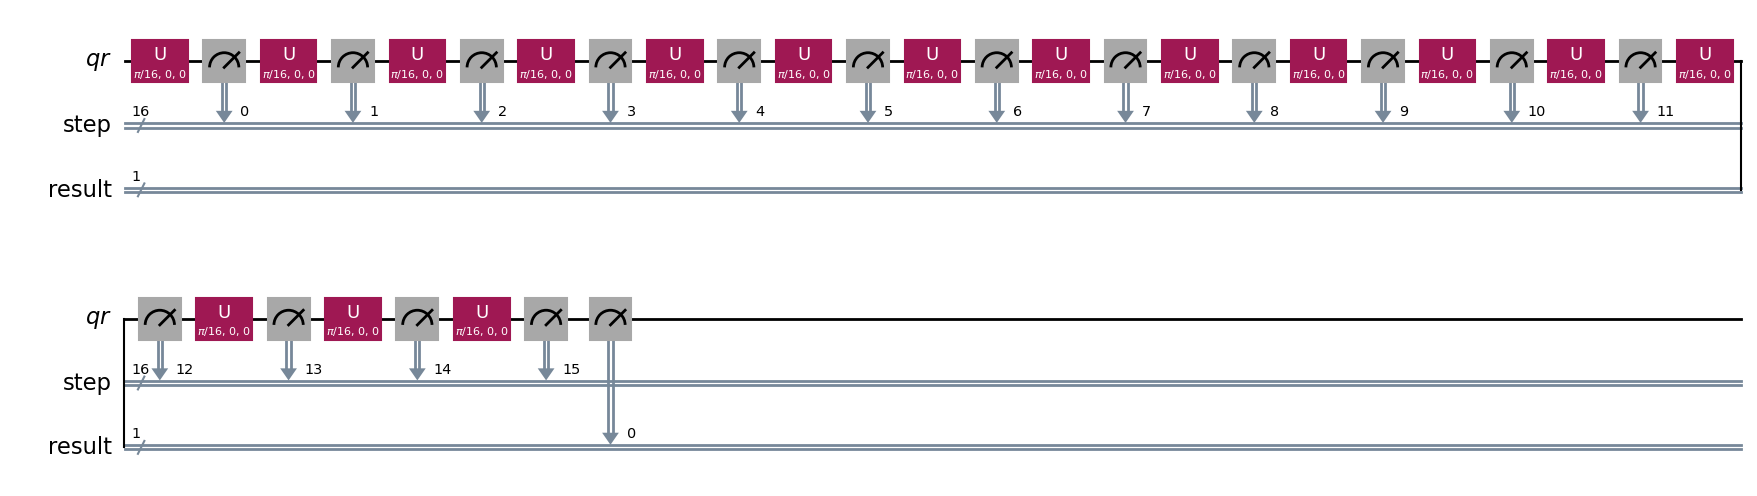

In [ ]:
qc = genCircuit(np.pi/32, genBox())
qc.draw(output='mpl')


In [ ]:
k = em(qc, shots=1000)
print(k)
#
# Unfortunately qiskit will label the result register backwards when
#   displaying the counts, so time goes from right to left in
#   the long string
#

{'1 1111111111110000': 5, '1 1100000000000000': 9, '0 0000011111000000': 1, '0 0001111000000000': 1, '0 0000000000000010': 1, '1 1000000000000000': 5, '1 1111111100000000': 16, '1 1111111111100000': 7, '1 1111110000000000': 12, '1 1111111000000000': 12, '1 1111111111111111': 7, '1 1111111111111000': 7, '1 1111111111111110': 8, '1 1111111111111100': 7, '0 0000000000000000': 849, '1 1111111111000000': 7, '1 1111000000000000': 7, '0 0001111111111100': 1, '0 0000000011111111': 1, '1 1111100000000000': 7, '0 0000001000000000': 1, '1 1111111110000000': 15, '1 1110000000000000': 14}


In [ ]:
for backend in service.backends():
    status = backend.status().to_dict()
    if status['operational'] and status['status_msg']=='active':
        print( pprint.pformat(backend.status().to_dict()) )

{'backend_name': 'ibm_brisbane',
 'backend_version': '',
 'operational': True,
 'pending_jobs': 18,
 'status_msg': 'active'}
{'backend_name': 'ibm_kyoto',
 'backend_version': '',
 'operational': True,
 'pending_jobs': 10,
 'status_msg': 'active'}
{'backend_name': 'ibm_osaka',
 'backend_version': '',
 'operational': True,
 'pending_jobs': 9,
 'status_msg': 'active'}
{'backend_name': 'ibm_sherbrooke',
 'backend_version': '',
 'operational': True,
 'pending_jobs': 11,
 'status_msg': 'active'}


In [ ]:
backend = service.least_busy(operational=True, simulator=False)
print(backend)

<IBMBackend('ibm_osaka')>


In [ ]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler

# Specify the system to target

# Transpile the circuit
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)
transpiled_circ = pass_manager.run(qc)
sampler = Sampler(backend)
job = sampler.run([transpiled_circ])
result = job.result()

RuntimeJobFailureError: 'Unable to retrieve job result. A buffer overflow occurred during result collection. Reduce the number of shots or measurements, or increase the rep_delay '

In [ ]:
for idx, pub_result in enumerate(result):
    print(f"Sample data for pub {idx}: {pub_result.data.step.get_counts()}")
for idx, pub_result in enumerate(result):
    print(f"Sample data for pub {idx}: {pub_result.data.result.get_counts()}")

Sample data for pub 0: {'0000000000000000': 4096}
Sample data for pub 0: {'1': 4034, '0': 62}


In [ ]:
End